# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 2 модели похожую по архитектуре на модель из ULMFit для задачи классификации текста (датасет - lenta_40k )
В моделях должно быть как минимум два рекуррентных слоя, а финальный вектор для классификации составляться из последнего состояния RNN (так делалось в семинаре), а также AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояния и результаты пулинга). В первой модели используйте обычные слои, а во второй Bidirectional. Рассчитайте по классовую точность/полноту/f-меру для каждой из модели (результаты не должны быть совсем близкие к нулю после обучения на хотя бы нескольких эпохах).

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.5.0


In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
# from IPython.display import Image
# from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
data = pd.read_csv('/kaggle/input/lenta-40k/lenta_40k.csv')

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [135]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

len(vocab)

354611

In [136]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

len(filtered_vocab)

24091

In [137]:
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)


In [138]:
id2word = {i:word for word, i in word2id.items()}

In [139]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [140]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [141]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [142]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [143]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [144]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

## Первая модель

In [155]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
drop = keras.layers.Dropout(0.5)(lstm1)
lstm2 = keras.layers.LSTM(128, return_sequences=True)(drop)

avg_pool = keras.layers.AveragePooling1D(pool_size=1)(lstm2)
max_pool = pooling2 = keras.layers.MaxPooling1D(pool_size=1)(lstm2)
concat = keras.layers.Concatenate()([lstm2, avg_pool, max_pool])

flat = keras.layers.Flatten()(concat)
dense = keras.layers.Dense(64, activation='relu')(flat)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [156]:
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_18 (Embedding)  │ (None, 200, 30)        │        722,790 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_31 (LSTM)            │ (None, 200, 128)       │         81,408 │ embedding_18[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 200, 128)       │              0 │ lstm_31[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_32 (LSTM)            │ (None, 200, 128)       │        131,584 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_9       │ (None, 200, 128)       │              0 │ lstm_32[0][0]          │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_9           │ (None, 200, 128)       │              0 │ lstm_32[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 200, 384)       │              0 │ lstm_32[0][0],         │
│ (Concatenate)             │                        │                │ average_pooling1d_9[0… │
│                           │                        │                │ max_pooling1d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 76800)          │              0 │ concatenate_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 64)             │      4,915,264 │ flatten_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 19)             │          1,235 │ dense_19[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,852,281 (22.32 MB)

 Trainable params: 5,852,281 (22.32 MB)

 Non-trainable params: 0 (0.00 B)

In [157]:
model.save('model.keras')
model = keras.models.load_model('model.keras')
model.save_weights('model.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [32]:
checkpoint = keras.callbacks.ModelCheckpoint('model_unet.weights.h5',
                                                monitor='val_rec@prec',
                                                verbose=1,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='max',
                                                save_freq='epoch'
                                               )
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01,
                                              patience=3,
                                              verbose=1,
                                              mode='max',
                                              )

In [158]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1024,
         epochs=10,
        callbacks=[checkpoint, early_stop])

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - loss: 2.4343 - rec@prec: 0.0047
Epoch 1: val_rec@prec did not improve from 0.69838
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 540ms/step - loss: 2.4265 - rec@prec: 0.0054 - val_loss: 1.3761 - val_rec@prec: 0.3458
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 1.1678 - rec@prec: 0.4754
Epoch 2: val_rec@prec did not improve from 0.69838
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 550ms/step - loss: 1.1655 - rec@prec: 0.4769 - val_loss: 1.0089 - val_rec@prec: 0.6087
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.7294 - rec@prec: 0.7491
Epoch 3: val_rec@prec did not improve from 0.69838
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 547ms/step - loss: 0.7289 - rec@prec: 0.7495 - val_loss: 0.9563 - val_rec@prec: 0.6461
Epoch 3: early stopping


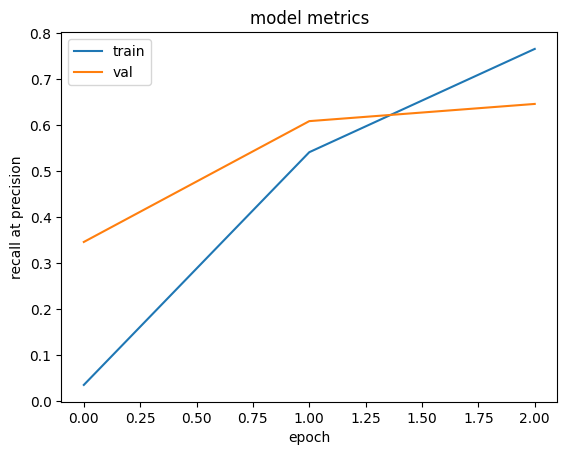

In [159]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
from sklearn.metrics import classification_report

In [160]:
pred = model.predict(X_valid).argmax(1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step


In [161]:
pred

array([ 9,  0, 15, ..., 15, 12, 12])

In [162]:
y_valid

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [163]:
y_val = np.argmax(y_valid, 1)

In [164]:
y_val

array([ 9,  0, 15, ..., 18, 12, 12])

In [165]:
print(classification_report(y_val.reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

                   precision    recall  f1-score   support

              Дом       0.83      0.58      0.68        66
  Наука и техника       0.83      0.69      0.75       160
         Из жизни       0.48      0.25      0.33        84
Силовые структуры       0.50      0.07      0.12        60
      Бывший СССР       0.76      0.68      0.72       159
             Крым       0.00      0.00      0.00         2
         Ценности       0.88      0.30      0.45        23
          Легпром       0.00      0.00      0.00         0
       Библиотека       0.00      0.00      0.00         0
         Культура       0.78      0.79      0.78       159
   69-я параллель       0.00      0.00      0.00         4
   Интернет и СМИ       0.46      0.59      0.52       132
        Экономика       0.74      0.86      0.80       239
    Культпросвет        0.00      0.00      0.00         1
           Бизнес       0.75      0.14      0.23        22
              Мир       0.68      0.82      0.74       

## Вторая модель

In [67]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
drop = keras.layers.Dropout(0.5)(lstm1)
lstm2 =  keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(drop)

avg_pool = keras.layers.AveragePooling1D(pool_size=1)(lstm2)
max_pool = pooling2 = keras.layers.MaxPooling1D(pool_size=1)(lstm2)
concat = keras.layers.Concatenate()([lstm2, avg_pool, max_pool])

flat = keras.layers.Flatten()(concat)
dense = keras.layers.Dense(64, activation='relu')(flat)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model_bd = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_bd.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [68]:
model_bd.save('model.keras')
model_bd = keras.models.load_model('model.keras')
model_bd.save_weights('model.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 36 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [69]:
model_bd.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1024,
         epochs=10,
        callbacks=[checkpoint, early_stop])

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - loss: 2.3894 - rec@prec: 0.0142
Epoch 1: val_rec@prec did not improve from 0.64923
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 2.3803 - rec@prec: 0.0158 - val_loss: 1.2671 - val_rec@prec: 0.4080
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.9951 - rec@prec: 0.5869
Epoch 2: val_rec@prec improved from 0.64923 to 0.67087, saving model to model_unet.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 0.9928 - rec@prec: 0.5885 - val_loss: 0.8755 - val_rec@prec: 0.6709
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.5364 - rec@prec: 0.8625
Epoch 3: val_rec@prec improved from 0.67087 to 0.69838, saving model to model_unet.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 0.5364 - rec@prec: 0.8624 - val_loss: 0.8775 - val_rec@prec: 0.6984
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3253 - rec@prec: 0.9489
Epoch 4: val_rec@prec did not improve from 0.69838
42/42 ━━━━━━━━━━━━━━━━━━━━ 44

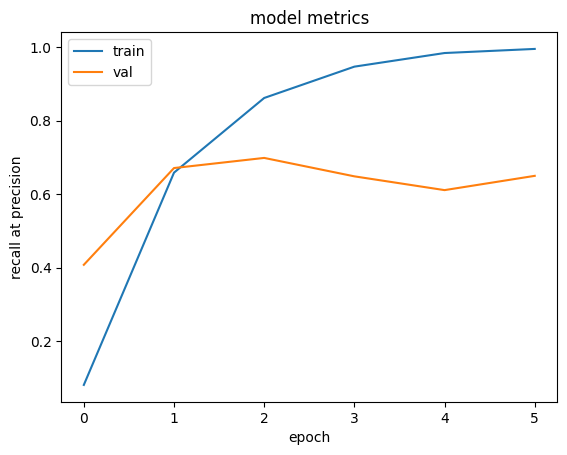

In [70]:
plt.plot(model_bd.history.history['rec@prec'])
plt.plot(model_bd.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
pred = model_bd.predict(X_valid).argmax(1)
print(classification_report(y_val.reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 539ms/step
                   precision    recall  f1-score   support

              Дом       0.75      0.70      0.72        66
  Наука и техника       0.65      0.84      0.73       160
         Из жизни       0.46      0.43      0.44        84
Силовые структуры       0.46      0.27      0.34        60
      Бывший СССР       0.74      0.79      0.76       159
             Крым       0.00      0.00      0.00         2
         Ценности       0.79      0.48      0.59        23
          Легпром       0.00      0.00      0.00         0
       Библиотека       0.00      0.00      0.00         0
         Культура       0.75      0.83      0.79       159
   69-я параллель       1.00      0.25      0.40         4
   Интернет и СМИ       0.57      0.61      0.59       132
        Экономика       0.86      0.72      0.78       239
    Культпросвет        0.00      0.00      0.00         1
           Бизнес       0.43      0.45      0.44        22
             

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите и сравните 3 модели:  
1) модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM
2) модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать
3) модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг



Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [72]:
from datasets import load_dataset

In [73]:
dataset = load_dataset("tner/wikiann", 'ru')

README.md:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

wikiann.py:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

The repository for tner/wikiann contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tner/wikiann.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


test.jsonl:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/2.63M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [166]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

len(vocab)

36015

In [167]:
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [168]:
id2word = {i:word for word, i in word2id.items()}

In [169]:
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [170]:
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [171]:
MAX_LEN = max(len(x) for x in X)

X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [172]:
labels2id = {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6,
    "PAD": 7
}
id2labels = {v:k for k,v in labels2id.items()} 

In [173]:
y = keras.preprocessing.sequence.pad_sequences(dataset['train']['tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = keras.preprocessing.sequence.pad_sequences(dataset['test']['tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

### Первая модель
Модель, в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM

In [184]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = keras.layers.GRU(128, return_sequences=True)(lstm_1)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model_1 = keras.Model(inputs=inputs, outputs=outputs)
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [185]:
model_1.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=512,
         epochs=10)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.7792 - loss: 1.4953 - val_accuracy: 0.8705 - val_loss: 0.3820
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.8819 - loss: 0.3480 - val_accuracy: 0.9164 - val_loss: 0.2834
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.9211 - loss: 0.2681 - val_accuracy: 0.9336 - val_loss: 0.2439
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.9378 - loss: 0.2312 - val_accuracy: 0.9364 - val_loss: 0.2233
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.9416 - loss: 0.2079 - val_accuracy: 0.9394 - val_loss: 0.2091
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.9486 - loss: 0.1882 - val_accuracy: 0.9455 - val_loss: 0.1887
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.9559 - loss: 0.1617 - val_accuracy: 0.9506 - val_loss: 0.1646
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.9618 - loss: 0.1307 - val_accuracy: 0.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


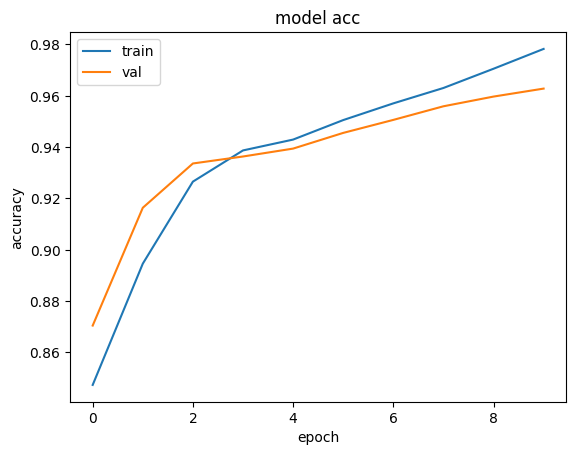

In [186]:
print(model_1.history.history.keys())
plt.plot(model_1.history.history['accuracy'])
plt.plot(model_1.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [187]:
pred_1 = model_1.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step


In [188]:
print(classification_report(y_test.reshape(-1), pred_1.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.51      0.33      0.40      4560
       B-ORG       0.45      0.08      0.14      4074
       B-PER       0.53      0.28      0.36      3542
       I-LOC       0.69      0.15      0.25      3060
       I-ORG       0.57      0.71      0.63      8008
       I-PER       0.86      0.49      0.63      7544
           O       0.76      0.95      0.85     40480
         PAD       1.00      1.00      1.00    468732

   micro avg       0.96      0.96      0.96    540000
   macro avg       0.67      0.50      0.53    540000
weighted avg       0.96      0.96      0.96    540000



## Вторая модель
Модель, в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection, нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать

In [130]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = keras.layers.LSTM(128, return_sequences=True)(lstm_1)
concat1 = keras.layers.concatenate((lstm_2, embeddings))
lstm_3 = keras.layers.LSTM(128, return_sequences=True)(concat1)
concat2 = keras.layers.concatenate((lstm_3, embeddings))

outputs = keras.layers.Dense(len(label2id), activation='softmax')(concat2)

model_2 = keras.Model(inputs=inputs, outputs=outputs)
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [131]:
model_2.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=512,
         epochs=10)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.7815 - loss: 1.4253 - val_accuracy: 0.8856 - val_loss: 0.4131
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.8998 - loss: 0.3808 - val_accuracy: 0.9295 - val_loss: 0.3020
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.9373 - loss: 0.2709 - val_accuracy: 0.9396 - val_loss: 0.2290
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.9427 - loss: 0.2084 - val_accuracy: 0.9473 - val_loss: 0.1889
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.9539 - loss: 0.1655 - val_accuracy: 0.9563 - val_loss: 0.1586
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.9640 - loss: 0.1296 - val_accuracy: 0.9619 - val_loss: 0.1326
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.9698 - loss: 0.1039 - val_accuracy: 0.9652 - val_loss: 0.1178
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.9764 - loss: 0.0825 - val_accu

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


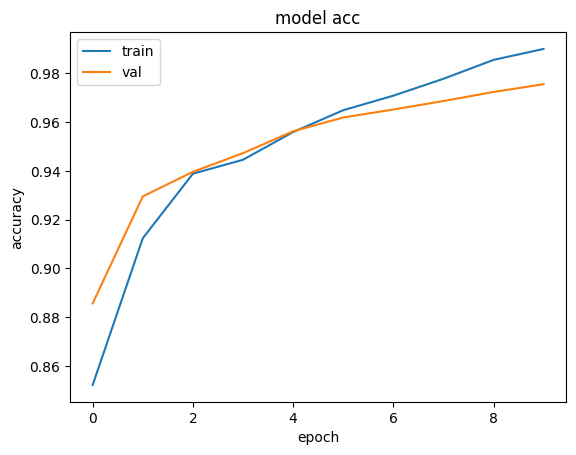

In [132]:
print(model_2.history.history.keys())
plt.plot(model_2.history.history['accuracy'])
plt.plot(model_2.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [133]:
pred_2 = model_2.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step


In [134]:
print(classification_report(y_test.reshape(-1), pred_2.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.88      0.45      0.59      4560
       B-ORG       0.72      0.44      0.55      4074
       B-PER       0.58      0.61      0.59      3542
       I-LOC       0.91      0.50      0.65      3060
       I-ORG       0.65      0.81      0.72      8008
       I-PER       0.82      0.88      0.85      7544
           O       0.88      0.93      0.90     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.80      0.70      0.73    540000
weighted avg       0.98      0.98      0.97    540000



### Третья модель
модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг

In [175]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = keras.layers.LSTM(128, return_sequences=True)(lstm_1)
conv1 = keras.layers.Conv1D(kernel_size=5, filters=64, padding='same',strides=1)(lstm_2)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=32, padding='same',strides=1)(conv1)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(conv2)

model_3 = keras.Model(inputs=inputs, outputs=outputs)
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [176]:
model_3.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=512,
         epochs=10)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.7788 - loss: 1.2570 - val_accuracy: 0.8680 - val_loss: 0.3442
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.8849 - loss: 0.3176 - val_accuracy: 0.9363 - val_loss: 0.2424
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.9367 - loss: 0.2227 - val_accuracy: 0.9438 - val_loss: 0.1831
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.9444 - loss: 0.1744 - val_accuracy: 0.9489 - val_loss: 0.1636
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.9505 - loss: 0.1523 - val_accuracy: 0.9529 - val_loss: 0.1488
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.9570 - loss: 0.1280 - val_accuracy: 0.9581 - val_loss: 0.1334
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.9656 - loss: 0.1003 - val_accuracy: 0.9633 - val_loss: 0.1291
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.9722 - loss: 0.0799 - val_accuracy: 0.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


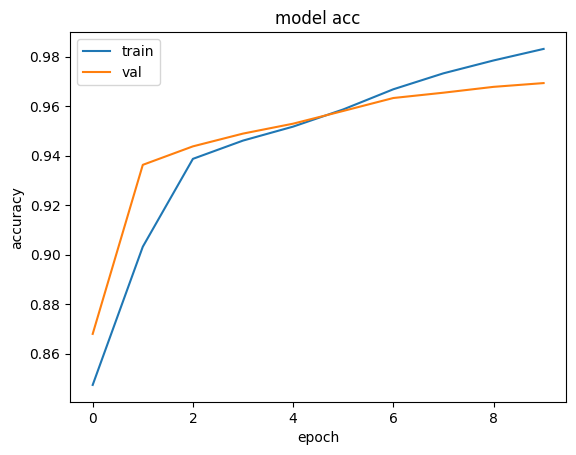

In [177]:
print(model_3.history.history.keys())
plt.plot(model_3.history.history['accuracy'])
plt.plot(model_3.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [178]:
pred_3 = model_3.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step


In [179]:
print(classification_report(y_test.reshape(-1), pred_3.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.57      0.24      0.34      4560
       B-ORG       0.54      0.38      0.45      4074
       B-PER       0.67      0.57      0.62      3542
       I-LOC       0.70      0.51      0.59      3060
       I-ORG       0.73      0.65      0.69      8008
       I-PER       0.86      0.67      0.76      7544
           O       0.79      0.94      0.86     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.73      0.62      0.66    540000
weighted avg       0.97      0.97      0.97    540000



### Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

Хуже всего метрики у первой модели (macro avg 0.53 по f1, у других 0.73 и 0.76, другие метрики тоже выше). Вторая и третья примерно наравне, но мне кажется, что вторая лучше всех, precision и recall по macro avg и weighted avg у нее выше всех.

In [181]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2labels[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2labels, len(ids))
    
    return list(zip(tokens, labels))

In [191]:
# 1ая модель не может определить PER
label_seq('Бобик гостил в Вологде у Валентины из МГУ, и она потом позвала его на каток в центре города.', word2id, id2labels, MAX_LEN, model_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[('Бобик', 'O'),
 ('гостил', 'O'),
 ('в', 'O'),
 ('Вологде', 'I-ORG'),
 ('у', 'O'),
 ('Валентины', 'O'),
 ('из', 'O'),
 ('МГУ', 'O'),
 (',', 'O'),
 ('и', 'O'),
 ('она', 'O'),
 ('потом', 'O'),
 ('позвала', 'O'),
 ('его', 'O'),
 ('на', 'O'),
 ('каток', 'O'),
 ('в', 'O'),
 ('центре', 'O'),
 ('города', 'B-LOC'),
 ('.', 'O')]

In [197]:
label_seq('Я много лет проработал на ЧМК, многие из коллег уже старые, например, Иван Василич, он родом из Сима.', word2id, id2labels, MAX_LEN, model_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


[('Я', 'O'),
 ('много', 'O'),
 ('лет', 'O'),
 ('проработал', 'O'),
 ('на', 'O'),
 ('ЧМК', 'O'),
 (',', 'O'),
 ('многие', 'O'),
 ('из', 'O'),
 ('коллег', 'O'),
 ('уже', 'O'),
 ('старые', 'O'),
 (',', 'O'),
 ('например', 'O'),
 (',', 'O'),
 ('Иван', 'B-LOC'),
 ('Василич', 'O'),
 (',', 'O'),
 ('он', 'O'),
 ('родом', 'O'),
 ('из', 'O'),
 ('Сима', 'O'),
 ('.', 'O')]

In [192]:
# 2ая модель очень любит лейблы ORG, в целом она правда лучше всех определяет сущности
label_seq('Бобик гостил в Вологде у Валентины из МГУ, и она потом позвала его на каток в центре города.', word2id, id2labels, MAX_LEN, model_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


[('Бобик', 'B-PER'),
 ('гостил', 'I-ORG'),
 ('в', 'O'),
 ('Вологде', 'B-LOC'),
 ('у', 'O'),
 ('Валентины', 'I-ORG'),
 ('из', 'O'),
 ('МГУ', 'O'),
 (',', 'O'),
 ('и', 'O'),
 ('она', 'O'),
 ('потом', 'O'),
 ('позвала', 'O'),
 ('его', 'O'),
 ('на', 'O'),
 ('каток', 'O'),
 ('в', 'O'),
 ('центре', 'O'),
 ('города', 'B-ORG'),
 ('.', 'O')]

In [198]:
label_seq('Я много лет проработал на ЧМК, многие из коллег уже старые, например, Иван Василич, он родом из Сима.', word2id, id2labels, MAX_LEN, model_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


[('Я', 'O'),
 ('много', 'O'),
 ('лет', 'O'),
 ('проработал', 'O'),
 ('на', 'O'),
 ('ЧМК', 'O'),
 (',', 'O'),
 ('многие', 'O'),
 ('из', 'O'),
 ('коллег', 'O'),
 ('уже', 'O'),
 ('старые', 'B-ORG'),
 (',', 'O'),
 ('например', 'O'),
 (',', 'O'),
 ('Иван', 'B-ORG'),
 ('Василич', 'I-ORG'),
 (',', 'O'),
 ('он', 'O'),
 ('родом', 'O'),
 ('из', 'O'),
 ('Сима', 'O'),
 ('.', 'O')]

In [193]:
# 3яя модель в основном определяет LOC, но не всегда успешно, тоже не определяет PER
label_seq('Бобик гостил в Вологде у Валентины из МГУ, и она потом позвала его на каток в центре города.', word2id, id2labels, MAX_LEN, model_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[('Бобик', 'O'),
 ('гостил', 'O'),
 ('в', 'O'),
 ('Вологде', 'B-LOC'),
 ('у', 'B-LOC'),
 ('Валентины', 'O'),
 ('из', 'O'),
 ('МГУ', 'O'),
 (',', 'O'),
 ('и', 'O'),
 ('она', 'O'),
 ('потом', 'O'),
 ('позвала', 'O'),
 ('его', 'O'),
 ('на', 'O'),
 ('каток', 'O'),
 ('в', 'O'),
 ('центре', 'O'),
 ('города', 'B-LOC'),
 ('.', 'O')]

In [199]:
label_seq('Я много лет проработал на ЧМК, многие из коллег уже старые, например, Иван Василич, он родом из Сима.', word2id, id2labels, MAX_LEN, model_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[('Я', 'O'),
 ('много', 'O'),
 ('лет', 'O'),
 ('проработал', 'O'),
 ('на', 'O'),
 ('ЧМК', 'O'),
 (',', 'O'),
 ('многие', 'O'),
 ('из', 'O'),
 ('коллег', 'O'),
 ('уже', 'O'),
 ('старые', 'O'),
 (',', 'O'),
 ('например', 'O'),
 (',', 'O'),
 ('Иван', 'O'),
 ('Василич', 'O'),
 (',', 'O'),
 ('он', 'O'),
 ('родом', 'O'),
 ('из', 'O'),
 ('Сима', 'O'),
 ('.', 'O')]